In [1]:
# IBM notebook style
import ibmJupyterNotebookStyles
ibmJupyterNotebookStyles.apply_ibm_styles()

# Quantum feature maps

Quantum feature maps in quantum machine learning (QML) are the direct counterpart to feature maps in classical machine learning. Feature maps are a type of data encoding for creating richer representations of data that aid estimator performance—for example, to improve classification performance using a support vector machine (SVM) model. A rich representation means a nonlinear transformation of data vectors to higher-dimensional feature vectors. In other words, the dimensionality and interrelationships of the data changes—for example, from 2D to 3D. In this feature space, a separating hyperplane may then be easily computable.

Quantum feature maps are an integral component in kernel-based QML algorithms, like quantum kernel estimation (QKE), that can be used in a quantum-enhanced SVM and a variety of kernel-based estimators, variational quantum algorithms, and quantum neural networks. The QKE algorithm estimates the inner product between quantum feature vectors. In a later section, we offer an in-depth look at how quantum kernels are calculated.

In QML, the goal is to discover quantum models capable of finding patterns in data that are difficult to model through classical methods.<sup>1</sup><sup>, </sup><sup>2</sup> Classical computing can be inefficient for computing data that has complex patterns or requires high model performance. A step toward achieving quantum potential is to identify quantum feature maps and kernels that are inefficient to compute classically, so as to justify the use of a quantum computer.<sup>3</sup> However, these models must be proportional to the pattern complexity of the data in question.

This notebook first presents $Z$ and $ZZ$ feature maps belonging to a more general class of Pauli feature maps, which are presented in turn.<sup>3</sup> We then introduce a more general approach using parameterized quantum circuits.

## Preliminaries

### Data notation

A data set is represented as a set of data vectors $\text{X} = \{\bar{x}_j\}$ and all together as data matrix $\text{X}_{jk}$. A data vector has $N$ dimensions $\bar{x}\ = (x_1,\dots,x_N)$, where the dimensions have associated feature values $x_i$. The aim of data encoding can be summarized as mapping a data vector to a quantum state vector $\bar{x} \rightarrow |\bar{x}\rangle$.  The quantum state vector elements are complex values.

### Feature map notation

A feature map, $\phi$, maps a data vector to a quantum feature vector, $x_i\rightarrow\phi(x_i) = |\phi(x_i)\rangle\langle\phi(x_i)|$, where this density matrix is the correct object to consider.<sup>4</sup> However, this notebook interprets the feature mapping as $x_i \rightarrow |\phi(x_i)\rangle$, which simplifies the mathematics and reflects how the data is mapped with a quantum circuit $U(x_i)|0\rangle = |\phi(x_i)\rangle$.

## Python imports

In [2]:
# Qiskit imports
from qiskit import QuantumCircuit
from qiskit.quantum_info import Statevector
from qiskit.visualization.bloch import Bloch
from qiskit.visualization.state_visualization import _bloch_multivector_data
from qiskit.visualization import circuit_drawer
from qiskit.circuit.library import ZFeatureMap, ZZFeatureMap, PauliFeatureMap

from math import pi
import numpy as np

import matplotlib.pyplot as plt

## $Z$ feature map

We first discuss the $Z$ feature map (ZFM), which is a simple feature map that can be interpreted as a natural extension of phase encoding (revisit the “Phase encoding” section in the “Data encoding” notebook if necessary). We will then gradually build up to feature maps with richer structure for pedagogical purposes. 

The ZFM consists of alternating layers of single-qubit gates: Hadamard gate layers and phase gate layers. The quantum circuit that performs the feature mapping is represented as a unitary operator that acts on the initial state:

\begin{equation}
\mathscr{U}_{\text{ZFM}}(x_i)|0\rangle^{\otimes n}=|\phi(x_i)\rangle
\end{equation}

where $|0\rangle^{\otimes n}$ is the $n$-qubit ground state. This notation is used for consistency with Havlicek et al. 2019.<sup>3</sup> The data features $x_i$ are mapped one-to-one with corresponding qubits. For example, if you have 8 features representing a single product, then you would use 8 qubits. The ZFM circuit is composed of several repetitions, $r$, of a subcircuit comprised of Hadamard gate layers and phase gate layers. A Hadamard layer is made up of a Hadamard gate acting on every qubit in an $n$-qubit register, $H \otimes H \otimes \dots \otimes H = H^{\otimes n}$, within the same stage of the algorithm. This description also applies to a phase gate layer $P(x_i)^{\otimes n}$, which is a function of a data vector, whereas the Hadamard layer is not. The full ZFM circuit unitary is:

\begin{equation}
\mathscr{U}_{\text{ZFM}}(x_i)=\big(P(x_i)^{\otimes n} H^{\otimes n}\big)\big(P(x_i)^{\otimes n} H^{\otimes n}\big) \dots \big(P(x_i)^{\otimes n} H^{\otimes n}\big)=\prod_{k=1}^{r} P(x_i)^{\otimes n} H^{\otimes n},
\end{equation}

where curved brackets are used to clarify the repeated subcircuit. The data features, $x_i$, are mapped to the phase gates in the same way in all repetitions, $r$. The ZFM feature map state is a product state and is efficient for classical simulation.<sup>3</sup>

To start with a small example, a 2-qubit ZFM circuit is coded using Qiskit and drawn to display the simple circuit structure. In the example, a single repetition, $r=1$, is implemented with the data vector $\bar{x} = \left(\textstyle\frac{1}{2}\pi, \textstyle\frac{1}{3}\pi\right)$. See the “Data encoding” notebook for a discussion of rescaling data values. The ZFM circuit unitary operator acts on the initial state in the following way:

\begin{equation}
\mathscr{U}_{\text{ZFM}}(\bar{x})|00\rangle = P(\bar{x})^{\otimes 2} H^{\otimes 2}|00\rangle = \left( P\left(\textstyle\frac{1}{2}\pi\right)H|0\rangle \right) \otimes \left(P\left(\textstyle\frac{1}{3}\pi\right)H|0\rangle\right).
\end{equation}

The formula has been rearranged around the tensor product to emphasize the operations on each qubit. The following Qiskit code uses Hadamard and phase gates explicitly to show the structure of the ZFM:

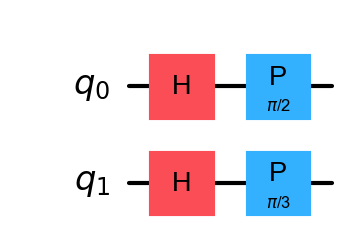

In [3]:
def capture_Statevector(quantum_circuit):
    return Statevector.from_instruction(quantum_circuit)
    
qc0 = QuantumCircuit(1)
qc1 = QuantumCircuit(1)

qc0.h(0)
state_qc00 = capture_Statevector(qc0)
qc0.p(pi/2, 0)
state_qc01 = capture_Statevector(qc0)

qc1.h(0)
state_qc10 = capture_Statevector(qc1)
qc1.p(pi/3, 0)
state_qc11 = capture_Statevector(qc1)

qubit0_states = state_qc00, state_qc01
qubit1_states = state_qc10, state_qc11
qubit_states = qubit0_states, qubit1_states

# Combine circuits qc0 and qc1 into 1 circuit
qc = QuantumCircuit(2)
qc.compose(qc0, [0], inplace=True)
qc.compose(qc1, [1], inplace=True)

qc.draw('mpl', scale=1.5)

In [4]:
def plot_Nstates(states, axis, plot_trace_points=True):
    """This function plots N states to 1 Bloch sphere"""
    bloch_vecs = [_bloch_multivector_data(s)[0] for s in states]

    if axis == None:
        bloch_plot = Bloch()
    else:
        bloch_plot = Bloch(axes=axis)
    
    bloch_plot.add_vectors(bloch_vecs)
    
    if len(states) > 1:
        
        def rgba_map(x, num):
            g = (0.95 - 0.05)/(num-1)
            i = 0.95 - g*num
            y = g*x + i
            return (0.0, y, 0.0, 0.7)
        
        num = len(states)
        bloch_plot.vector_color = [rgba_map(x, num) for x in range(1, num+1)]
    
    bloch_plot.vector_width = 3
    bloch_plot.vector_style = 'simple'

    if plot_trace_points:
        
        def trace_points(bloch_vec1, bloch_vec2):
            #bloch_vec = (x,y,z)
            n_points = 15
            thetas = np.arccos([bloch_vec1[2], bloch_vec2[2]])
            phis = np.arctan2([bloch_vec1[1], bloch_vec2[1]],
                              [bloch_vec1[0], bloch_vec2[0]])
            if phis[1] < 0:
                phis[1] = phis[1] + 2*pi
            angles0 = np.linspace(phis[0], phis[1], n_points)
            angles1 = np.linspace(thetas[0], thetas[1], n_points)

            xp = np.cos(angles0)*np.sin(angles1)
            yp = np.sin(angles0)*np.sin(angles1)
            zp = np.cos(angles1)
            pnts = [xp, yp, zp]
            bloch_plot.add_points(pnts)
            bloch_plot.point_color = 'k'
            bloch_plot.point_size = [4]*len(bloch_plot.points)
            bloch_plot.point_marker = ['o']

        for i in range(len(bloch_vecs)-1):
            trace_points(bloch_vecs[i], bloch_vecs[i+1])
    
    bloch_plot.sphere_alpha = 0.05
    bloch_plot.frame_alpha = 0.15
    bloch_plot.figsize = [4,4]

    bloch_plot.render()

        
def plot_2bloch_spheres(qubit_states, plot_trace_points):
    '''
    qubit_states is packed as (qubit0_states, qubit1_states)
    '''
    fig = plt.figure(figsize=(10, 10))
    num = 2
    # loop over 2 Bloch spheres
    for i in range(num):
        ax = fig.add_subplot(1, num, i+1, projection="3d")
        states_list = []
        for q in qubit_states[i]:
            states_list.append(q)
        plot_Nstates(states_list, ax, plot_trace_points)
        

plot_2bloch_spheres(qubit_states, plot_trace_points=True)

The Bloch spheres represent two different qubits in the qubit register. A feature value is encoded in each qubit. The green arrows represent the final encoded state, and the black dots are the reference state one step before.

We now encode the same data vector $\bar{x} = \left(\textstyle\frac{1}{2}\pi, \textstyle\frac{1}{3}\pi\right)$ to a ZFM circuit with three repetitions, $r=3$, using the Qiskit [`ZFeatureMap`](https://qiskit.org/documentation/stubs/qiskit.circuit.library.ZFeatureMap.html#qiskit.circuit.library.ZFeatureMap.assign_parameters) class, which altogether gives us the quantum feature map $\mathscr{U}_{\text{ZFM}}(\bar{x})$. By default in the `ZFeatureMap` class, parameters are multiplied by 2 before mapping to the phase gate $x \rightarrow P(\theta = 2x)$. To reproduce the same encodings as above, we divide by 2.

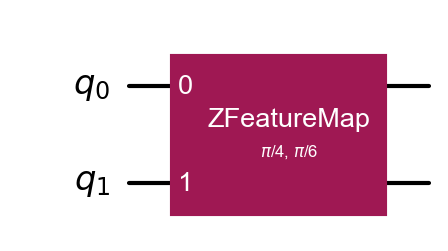

In [5]:
zfeature_map = ZFeatureMap(feature_dimension=2, reps=3)
zfeature_map = zfeature_map.assign_parameters([(1/2)*pi/2, (1/2)*pi/3])
#zfeature_map.decompose().draw('mpl', scale=1.5)
zfeature_map.draw('mpl', scale=1.5)

The ZFM feature map unitary for this circuit is $\mathscr{U}_{\text{ZFM}}(\bar{x}) = \prod_{k=1}^{3} P(\bar{x})^{\otimes 2} H^{\otimes 2}$.

In the following Qiskit code, the ZFM is built explicitly. We can input different numbers of repetitions and feature values. The resulting ZFM circuit is drawn and then the time evolution of the encoded states is plotted.

In [6]:
def capture_Statevector(quantum_circuit):
    return Statevector.from_instruction(quantum_circuit)

def apply_subcircuit(quantum_circuit, theta):
    quantum_circuit.h(0)
    quantum_circuit.p(theta, 0)
    return quantum_circuit

repetitions = 4
feature_value0 = 8*pi/5
feature_value1 = 4*pi/5

#Qubit0
qc0 = QuantumCircuit(1)
qubit0_states_list = []
for reps in range(repetitions):
    apply_subcircuit(qc0, feature_value0)
    qubit0_states_list.append(capture_Statevector(qc0))
    qc0.barrier()
    
#Qubit1
qc1 = QuantumCircuit(1)
qubit1_states_list = []
for reps in range(repetitions):
    apply_subcircuit(qc1, feature_value1)
    qubit1_states_list.append(capture_Statevector(qc1))
    qc1.barrier()
    
qubit_states = qubit0_states_list, qubit1_states_list

# Combine circuits qc0 and qc1 into 1 circuit
qc = QuantumCircuit(2)
qc.compose(qc0, [0], inplace=True)
qc.compose(qc1, [1], inplace=True)

qc.draw('mpl', scale=1.5)

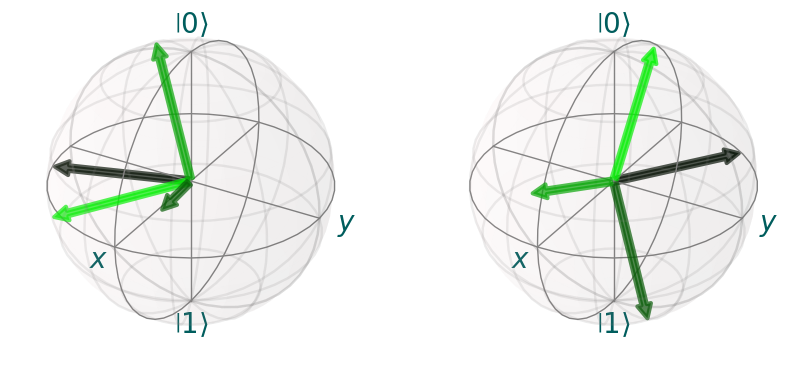

In [7]:
plot_2bloch_spheres(qubit_states, plot_trace_points=False)

The Bloch spheres represent two different qubits in the qubit register, which altogether have a product state. The light green arrows represent the final encoded states. The arrows show time evolution, one for each repetition from dark $\rightarrow$ light green. The black arrows for the first repetition are on the Bloch equator. Subsequent repetitions explore the larger Bloch sphere. These states correspond to the states at the barrier positions in the circuit above. The final feature state is used to build the quantum kernel circuit.

## $ZZ$ feature map

The $ZZ$ feature map (ZZFM) extends the ZFM with the inclusion of two-qubit entangling gates,
the $ZZ$-rotation gate $R_{ZZ}(\theta)$. The ZZFM is conjectured to be generally expensive to compute on a classical computer, unlike the ZFM. 

$R_{ZZ}(\theta)$ implements a $ZZ$-interaction and is maximally entangling for $\theta = \textstyle{\frac{1}{2}}\pi$. $R_{ZZ}(\theta)$ can be decomposed into a series of gates on two qubits, as shown in the following Qiskit code using the [RZZ gate](https://qiskit.org/documentation/stubs/qiskit.circuit.library.RZZGate.html) and the `QuantumCircuit` class method ```decompose```. We encode a data feature value $x=\pi$.

In [8]:
# Commented out code used to produce both quantum circuits below
#qc = QuantumCircuit(2)
#qc.rzz(pi,0,1)
#qc.draw('mpl', scale=1.5)
#qc.decompose().draw('mpl', scale=1.5)

from IPython.display import Image
Image("figs/Rzz_decomposed_circuit.jpg", width=600)

Data is mapped with a phase rotation $P(\theta) = e^{i\theta/2}R_Z(\theta)$ on the second qubit. The $R_{ZZ}(\theta)$ gate entangles the two qubits on which it operates by a degree of entanglement determined by the encoded feature value.

ZZFM is a second-order circuit, while ZFM is a first-order circuit, which is why the first part is a ZFM and the extended part is a set of $R_{ZZ}(\theta)$ gates. To map a two-dimensional data vector $\bar{x} = (x_0, x_1)$ with a two-qubit ZZFM and one repetition, we use the following code:

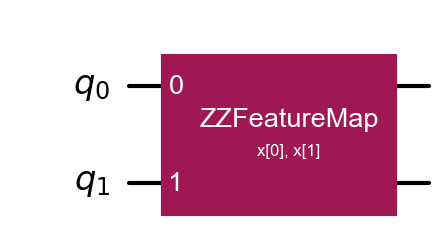

In [9]:
feature_dim=2
zzfeature_map = ZZFeatureMap(feature_dimension=feature_dim, entanglement='linear', reps=1)
#zzfeature_map.decompose().draw('mpl', scale=1.5)
zzfeature_map.draw('mpl', scale=1.5)

By default in Qiskit, the features $(x_0, x_1)$ are mapped together to $R_{ZZ}(\theta)$ by an inner mapping function $\theta = \phi(x_0, x_1) = 2(\pi-x_0)(\pi-x_1)$. Qiskit allows the user to customize the function $\phi$ (or $\phi_S$) as a preprocessing step.

To map a four-dimensional data vector $\bar{x} = (x_0, x_1, x_2, x_3)$ to a four-qubit ZZFM with one repetition, use the following circuit:

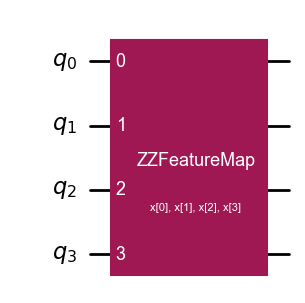

In [10]:
feature_dim=4
zzfeature_map = ZZFeatureMap(feature_dimension=feature_dim, entanglement='linear', reps=1)
#zzfeature_map.decompose().draw('mpl', scale=1)
zzfeature_map.draw('mpl', scale=1)

We can see the structure of the linear entanglement scheme, where nearest-neighbor pairs of qubits in this circuit are entangled. Another built-in entanglement scheme in Qiskit that can be passed to the `ZZFeatureMap` class is the full entanglement scheme, where all pairs of qubits are entangled to each other.

In general, a ZZFM circuit comprised of $r$ repetitions is:

\begin{equation}
\mathscr{U}_{\text{ZZFM}}(\bar{x}) = \prod_{k=1}^{r} U(\bar{x}) H^{\otimes n}
\end{equation},

where $U(\bar{x})$ contains the phase gate layer and ZZ-gate layer structured by an entanglement scheme. The ZZFM circuit drawing above is represented by $U(\bar{x})H^{\otimes 4}$. The following image shows a five-qubit quantum circuit with $r=2$, from Havlicek et al. 2019.<sup>3</sup> The unitary is $\mathscr{U}_{\text{ZZFM}}(\bar{x}) = \prod_{k=1}^{2} U(\bar{x}) H^{\otimes 5}$.

In [11]:
from IPython.display import Image
Image("figs/feature map circuit.jpg", width=600)

## Pauli feature map

The Pauli feature map (PFM) is the superset of the ZFM and ZZFM discussed above and takes the same form:

\begin{equation}
\mathscr{U}_{\text{ZZFM}}(\bar{x}) = \prod_{k=1}^{r} U(\bar{x}) H^{\otimes n}
\end{equation}.

However, for PFM, $U(\bar{x})$ is generalized to a Pauli expansion unitary operator. Here we present a more generalized derivation of the feature maps considered so far:

\begin{equation}
U(\bar{x}) = \exp\left(i \displaystyle\sum_{S\subseteq[n]} \phi_S(\bar{x}) \prod_{i \in S} \sigma_i \right)
\end{equation},

where $\sigma_i$ is a Pauli operator, $\sigma_i \in \{I,X,Y,Z\}$, and $S$ is the set connectivities between qubits (see the [Qiskit `PauliFeatureMap` class documentation](https://qiskit.org/documentation/stubs/qiskit.circuit.library.PauliFeatureMap.html)). In the ZZFM, the operator $\sigma_i$ is restricted to $Z_i$.

This is a unitary evolution operator, $\exp(it\mathcal{H})$, for a Hamiltonian, $\mathcal{H}$, similar to the Ising model, where the time parameter, $t$, is replaced with data values to drive the evolution. The expansion of this unitary operator gives the PFM circuit. The entangling connectivities in $S$ can be interpreted as Ising couplings in a spin lattice.

For a simple two-qubit ZZFM, the unitary takes the following form. The inner mapping function, $\phi_S(\bar{x})$, on the data values for single-qubit gates is $\phi_S(x_i)=x_i$, and for two-qubit gates is $\phi_S(\bar{x})=(\pi - x_0)(\pi - x_1)$. The second-order Pauli evolution unitary is expanded to single- and two-qubit gates:

\begin{equation}
U(\bar{x}) = \exp\left(i\phi_S(\bar{x})Z_1 Z_0 + i \left( x_1 Z_1 + x_0 Z_0 \right)\right) \propto R_{ZZ}(\bar{x})\left(R_{Z}(x_1) \otimes R_{Z}(x_0) \right) 
\end{equation},

where $R_Z(\theta) = \exp\left(-i \textstyle{\frac{\theta}{2}} Z\right)$ and $R_{ZZ}(\theta) = \exp\left(-i \textstyle{\frac{\theta}{2}}ZZ\right)$. The full circuit, $\mathscr{U}_{\text{ZZFM}}(\bar{x})$, for this example is the same as was shown for ZZFM and is displayed here again.

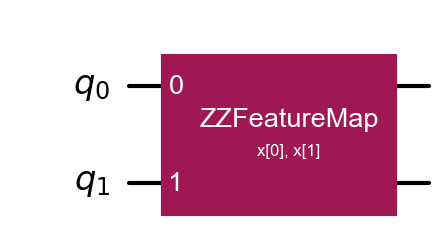

In [12]:
feature_dim=2
zzfeature_map = ZZFeatureMap(feature_dimension=feature_dim, entanglement='linear', reps=1)
#zzfeature_map.decompose().draw('mpl', scale=1.5)
zzfeature_map.draw('mpl', scale=1.5)

Now we consider a similar expansion for the example of Pauli $Y$ and $XX$ operators representing those Ising-type interactions. Qiskit provides a [`PauliFeatureMap`](https://qiskit.org/documentation/stubs/qiskit.circuit.library.PauliFeatureMap.html) class for instantiating a PFM with a choice of single- and $N$-qubit gates, which in this example will be passed as Pauli strings `‘Y’` and `‘XX’`. Typically, $N$ is 1 or 2 for single- and two-qubit interactions, respectively. The entanglement scheme is “linear,” meaning that only nearest-neighbor qubits in the quantum circuit are coupled. Note that this does not correspond to nearest-neighbor qubits on the IBM Quantum system itself, as this quantum circuit is an abstraction layer (see “Hardware-efficient feature map” section below).

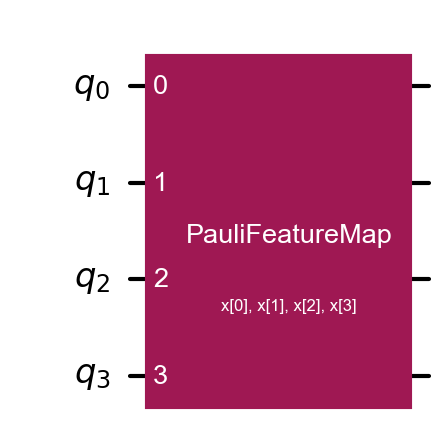

In [13]:
feature_dim=4
pauli_feature_map = PauliFeatureMap(feature_dimension=feature_dim,
                                    entanglement='linear',
                                    reps=1,
                                    paulis=['Y', 'XX'])
#pauli_feature_map.decompose().draw('mpl', scale=1.5)
pauli_feature_map.draw('mpl', scale=1.5)

Qiskit provides a parameter, $\alpha$, in Pauli feature maps to control the speed of Pauli rotations.

\begin{equation}
U(\bar{x}) = \exp\left(i \alpha \displaystyle\sum_{S\subseteq[n]} \phi_S(\bar{x}) \prod_{i \in S} \sigma_i \right)
\end{equation}

The default value of $\alpha$ is $2$. By optimizing its value in the interval — for example, $[0,4]$ — one can better align a quantum kernel to the data. For example, observe in the animation below how the decision boundary for the Circles data set produced by the $Z$ feature map ($\sigma_i=Z$) changes with different values of $\alpha$.

![](figs/decision_boundary.gif)

### Gallery of Pauli feature maps

In general, it is helpful to visualize Pauli feature maps for two-qubit circuits to get a better picture of the range of possibilities.

In [14]:
feature_dim=2
fig, axs = plt.subplots(9, 2)
i_plot=0
for paulis in [['I'],['X'],['Y'],['Z'], \
               ['XX'],['XY'],['XZ'],['YY'],['YZ'],['ZZ'], \
               ['X','ZZ'],['Y','ZZ'],['Z','ZZ'], \
               ['X','YZ'],['Y','YZ'],['Z','YZ'], \
               ['YY','ZZ'], ['XY','ZZ']]:
    pfm = PauliFeatureMap(feature_dimension=feature_dim,paulis=paulis,reps=1)
    circuit_drawer(pfm.decompose(), output='mpl', style={'backgroundcolor': '#EEEEEE'}, \
                   ax=axs[int((i_plot - i_plot%2)/2),i_plot%2])
    axs[int((i_plot - i_plot%2)/2),i_plot%2].title.set_text(paulis)
    i_plot += 1
    
fig.set_figheight(16)
fig.set_figwidth(16)

The above can, of course, be extended to include other permutations and repetitions of Pauli matrices. Learners are encouraged to experiment with those options.

## Hardware-efficient feature map

Quantum hardware efficiency involves minimizing the quantum hardware requirements of a quantum algorithm, such as a feature map, in the interest of reducing noise and errors in the computation. When running quantum circuits on near-term quantum computers, there are many strategies to mitigate noise inherent to the hardware. One main strategy for hardware efficiency is the minimization of the depth of the quantum circuit so that deleterious noise and decoherence have less time to corrupt the computation. The depth of a quantum circuit is the number of time-aligned gate steps required to complete the entire computation (after circuit optimization).<sup>6</sup> When programming quantum circuits and running them on hardware with Qiskit, the depth of the quantum circuits that will ultimately be run on the hardware can be decreased in transpilation.

Transpilation is the process of converting the quantum circuit in a high-level abstraction layer written in Qiskit code to a quantum circuit that will map directly to the quantum computer, given what the hardware configuration allows. The transpilation process involves circuit optimization for hardware efficiency. A first step is using the ```optimization``` argument that can be set from 0 up to a highest level of 3. For greater control and customizability, the transpiler pipeline can be managed with the [Qiskit Pass Manager](https://qiskit.org/documentation/tutorials/circuits_advanced/04_transpiler_passes_and_passmanager.html). Refer to the [Qiskit Transpiler documentation](https://qiskit.org/documentation/apidoc/transpiler.html) for more information on transpilation.

The quantum hardware configuration has a native set of single- and two-qubit gates. This means all gates in Qiskit code have to be transpiled into the set of native hardware gates. For example, in Montreal and other IBM Quantum systems, the native or basis gates are `{CX, ID, RZ, SX, X}`. These are the two-qubit controlled-NOT gate, and single-qubit gates called identity, $Z$-rotation, square root of NOT, and NOT, respectively, providing a universal set. When implementing multi-qubit gates as an equivalent subcircuit, physical two-qubit $CX$ gates are required, along with other single-qubit gates available in hardware (see below figure and caption). In addition, to perform a two-qubit gate on a pair of qubits that are not physically coupled, SWAP gates are added to move qubit states between qubits to enable coupling, which leads to an unavoidable extension of the circuit.

In Havlicek et al. 2019,<sup>3</sup> one way the authors achieve hardware efficiency is by using the $ZZ$ feature map because it is a second-order expansion (see the “$ZZ$ feature map” section above). An $N$-order expansion has $N$-qubit gates. IBM Quantum systems do not have native $N$-qubit gates, where $N>2$, so to implement them would require decomposition into two-qubit CNOT gates available in hardware. A second way the authors minimize depth is by choosing a $ZZ$ coupling topology that maps directly to the architecture couplings. A further optimization they undertake is targeting a higher-performing, suitably connected hardware subcircuit. Additional things to consider are minimizing the number of feature map repetitions and choosing a customized low-depth or “linear” entangling scheme instead of the “full” scheme that entangles all qubits.



In [15]:
from IPython.display import Image
Image("figs/ibm_q Montreal 09152021.jpg", width=700)

The above graphic shows a network of nodes and edges that represent physical qubits and hardware couplings, respectively. The coupling map and performance of Montreal (Sep 2021) is shown with all possible two-qubit CNOT coupling gates. Qubits are color-coded on a scale based on the T1 relaxation time in microseconds (μs), where longer T1 times are better and in a lighter shade. The coupling edges are color-coded by CNOT error, where darker shades are better. Information on the hardware specification can be accessed in the hardware backend configuration schema ```IBMQBackend.configuration()```.

## References

1. <a id='Biamonte2018'></a>Jacob Biamonte et al. “Quantum Machine Learning.” *Nature*, vol. 549 (2017): 195–202. https://arxiv.org/abs/1611.09347.

2. <a id='Liu2021'></a>Yunchao Liu, Srinivasan Arunachalam, Kristan Temme, “A Rigorous and Robust Quantum Speed-up in Supervised Machine Learning.” *Nature Physics*, vol. 17 (2021): 1013–1017. https://arxiv.org/abs/2010.02174.

3. <a id='Havlicek2018'></a>Vojtech Havlicek et al. “Supervised Learning with Quantum Enhanced Feature Spaces.” *Nature*, vol. 567 (2019): 209–212. https://arxiv.org/abs/1804.11326.

4. <a id='Schuld2021'></a>Maria Schuld. “Supervised Quantum Machine Learning Models Are Kernel Methods.” arXiv:2101.11020. Last updated April 17, 2021. https://arxiv.org/abs/2101.11020.

5. <a id='Suzuki2019'></a>Yudai Suzuki et al. “Analysis and Synthesis of Feature Map for Kernel-Based Quantum Classifier.” *Quantum Machine Intelligence*, vol. 2 (2020): 1–9. https://arxiv.org/abs/1906.10467.

6. <a id='QiskitQuantumCircuit.depth2021'></a> “qiskit.circut.QuantumCircuit.depth.” *Qiskit*. https://qiskit.org/documentation/stubs/qiskit.circuit.QuantumCircuit.depth.html#qiskit.circuit.QuantumCircuit.depth.

<span style="font-size:10pt; font-weight:bold;"> &copy; Copyright IBM Corp. 2023 <br/>This content is categorized as an “existing” IBM asset as part of the IBM Quantum Accelerator contract. </span>